In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

# Load Dataset

In [62]:
df = pd.read_csv('AB_NYC_2019.csv')

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [66]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# EDA

In [69]:
def explore_dataframe(df, head=5):
    sections = {
        "Shape": df.shape,
        "Missing Values": df.isnull().sum(),
        "Quantiles": df.describe().T,
    }

    for section, content in sections.items():
        print(f"{'#' * 20} {section} {'#' * 20}")
        print(content)
        print()
explore_dataframe(df)


#################### Shape ####################
(48895, 16)

#################### Missing Values ####################
id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

#################### Quantiles ####################
                                  count          mean           std  \
id                              48895.0  1.901714e+07  1.098311e+07   
host_id                         48

In [71]:
# Imputate reviews_per_month
imputed_df = df[["reviews_per_month"]]
rs = RobustScaler()
imputed_df_scaled = pd.DataFrame(rs.fit_transform(imputed_df), columns=imputed_df.columns)
imputer = KNNImputer(n_neighbors=5)
imputed_df_filled = pd.DataFrame(imputer.fit_transform(imputed_df_scaled), columns=imputed_df.columns)
imputed_df_final = pd.DataFrame(rs.inverse_transform(imputed_df_filled), columns=imputed_df.columns)
df["reviews_per_month"] = imputed_df_final

In [72]:
# Capturing Numeric and Categorical Variables
def identify_columns(df, categorical_threshold=10, cardinal_threshold=20):
    
    # Identify categorical columns
    categorical_variables = [col for col in df.columns if df[col].dtypes == "O"]
    numeric_as_categorical = [
        col for col in df.columns if df[col].nunique() < categorical_threshold and df[col].dtypes != "O"
    ]

    # Identify high-cardinality categorical columns
    cardinal_variables = [
        col for col in df.columns if df[col].nunique() > cardinal_threshold and df[col].dtypes == "O"
    ]

    # Combine actual categorical and numeric-as-categorical variables
    categorical_variables = [
        col for col in categorical_variables + numeric_as_categorical if col not in cardinal_variables
    ]

    # Identify numeric columns
    numeric_variables = [
        col for col in df.columns if df[col].dtypes != "O" and col not in numeric_as_categorical
    ]

    print(f"Total Observations: {df.shape[0]}")
    print(f"Total Variables: {df.shape[1]}")
    print(f"Categorical Variables: {len(categorical_variables)}")
    print(f"Numeric Variables: {len(numeric_variables)}")
    print(f"Cardinal Variables: {len(cardinal_variables)}")
    print(f"Numeric as Categorical: {len(numeric_as_categorical)}")
    return categorical_variables, numeric_variables, cardinal_variables, numeric_as_categorical


categorical_variables, numeric_variables, cardinal_variables, numeric_as_categorical = identify_columns(df)
print("Categorical Variables:", categorical_variables)
print("Numeric Variables:", numeric_variables)
print("Cardinal Variables:", cardinal_variables)
print("Numeric as Categorical:", numeric_as_categorical)


Total Observations: 48895
Total Variables: 16
Categorical Variables: 2
Numeric Variables: 10
Cardinal Variables: 4
Numeric as Categorical: 0
Categorical Variables: ['neighbourhood_group', 'room_type']
Numeric Variables: ['id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
Cardinal Variables: ['name', 'host_name', 'neighbourhood', 'last_review']
Numeric as Categorical: []


Summary for 'neighbourhood_group':


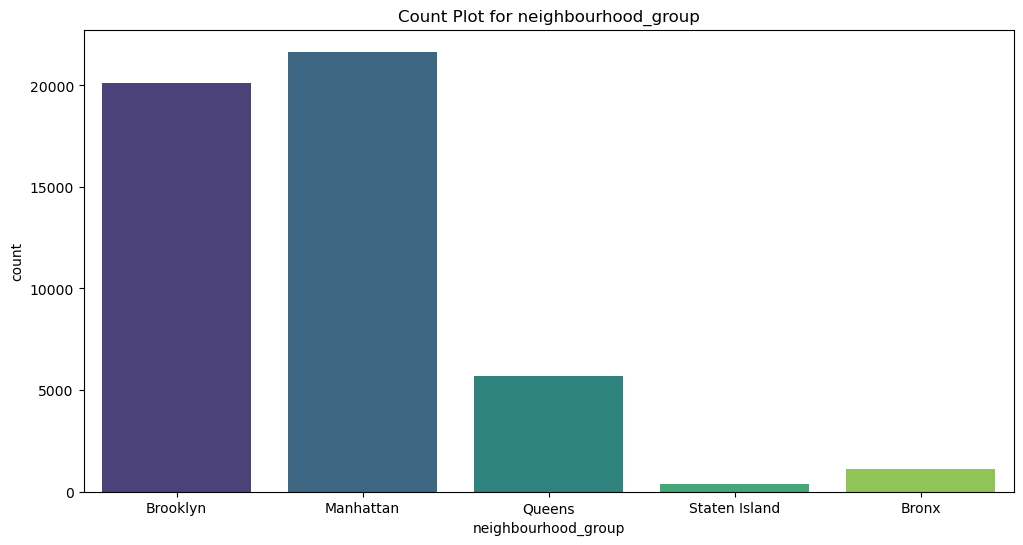

Summary for 'room_type':


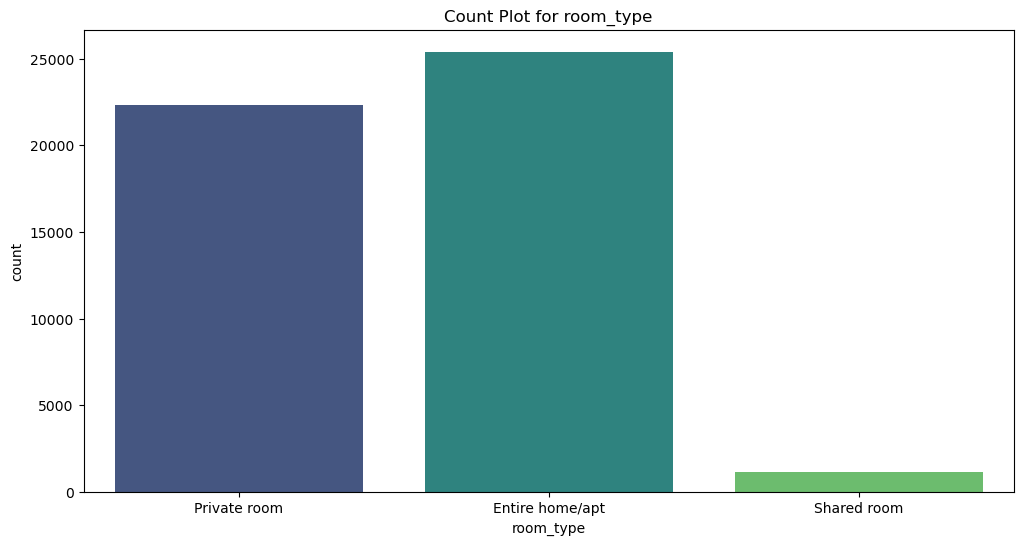

In [73]:
# Analysis of Categorical Variables
def summarize_categorical(dataframe, column_name, display_plot=False):
    summary = pd.DataFrame({
        "Count": dataframe[column_name].value_counts(),
        "Percentage": 100 * dataframe[column_name].value_counts() / len(dataframe)
    })
    print(f"Summary for '{column_name}':")

    
    if display_plot:
        plt.figure(figsize=(12, 6))
        sns.countplot(x=column_name, data=dataframe, palette="viridis")
        plt.title(f"Count Plot for {column_name}")
        plt.show()

for column in categorical_variables:
    summarize_categorical(df, column, display_plot=True)


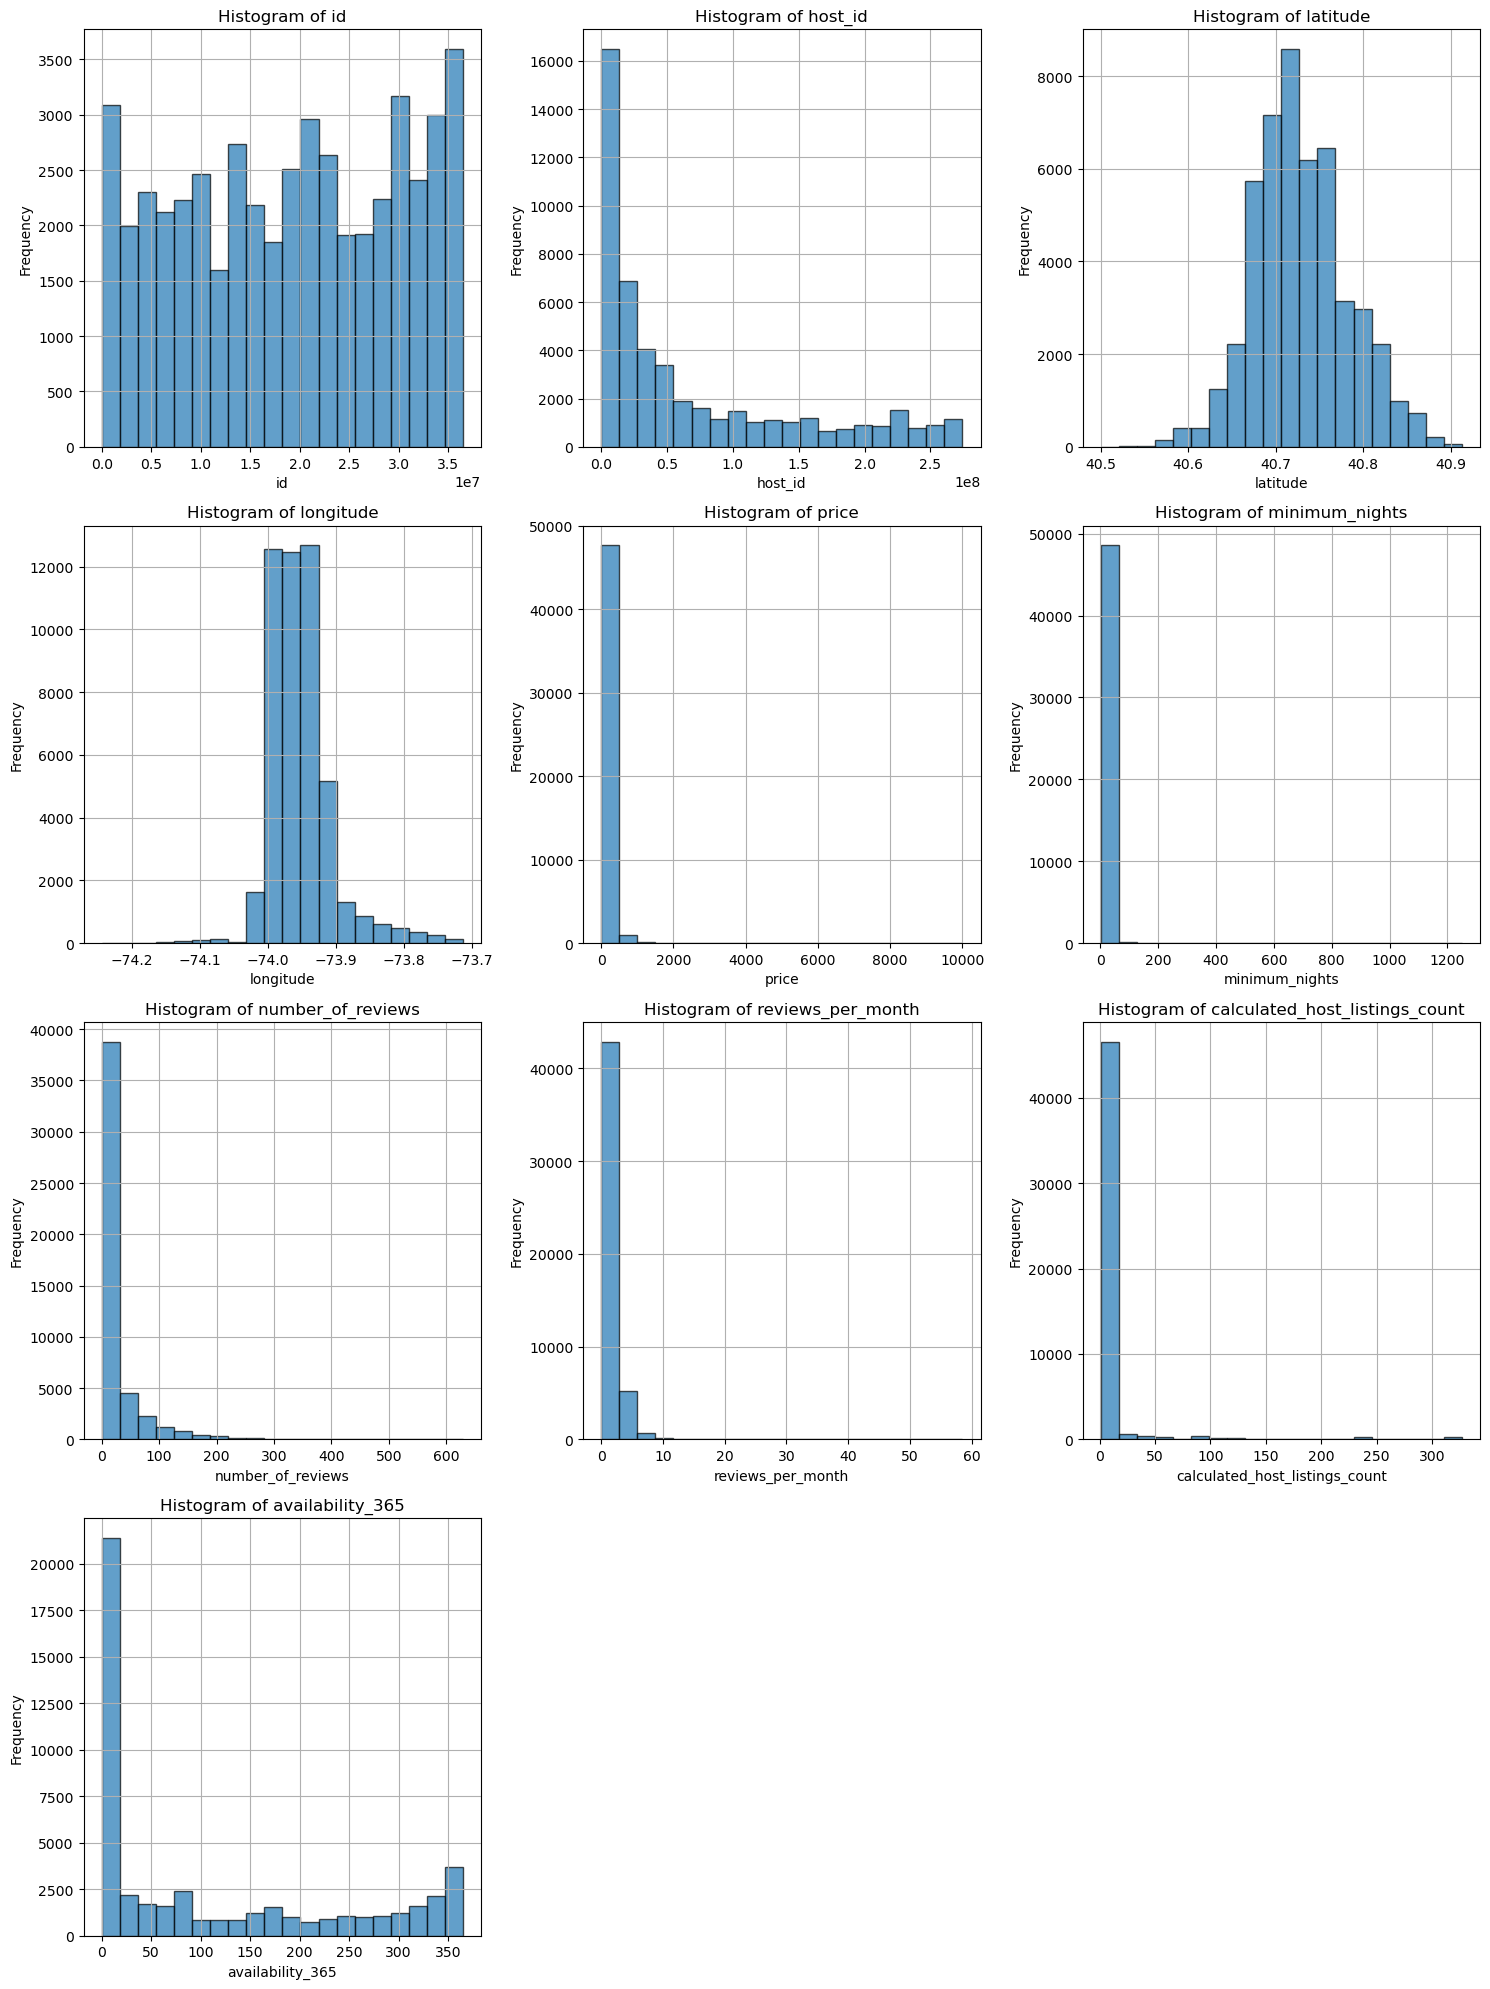

In [74]:
#Categorical Variables
def plot_numerical_histograms(dataframe, numerical_columns):
    num_cols = len(numerical_columns)
    plt.figure(figsize=(15, 5 * ((num_cols // 3) + 1))) 
    
    for idx, column in enumerate(numerical_columns, 1):
        plt.subplot((num_cols // 3) + 1, 3, idx)  # Subplots
        dataframe[column].hist(bins=20, alpha=0.7, edgecolor="black")
        plt.title(f"Histogram of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
    
    plt.tight_layout() 
    plt.show()

plot_numerical_histograms(df, numeric_variables)


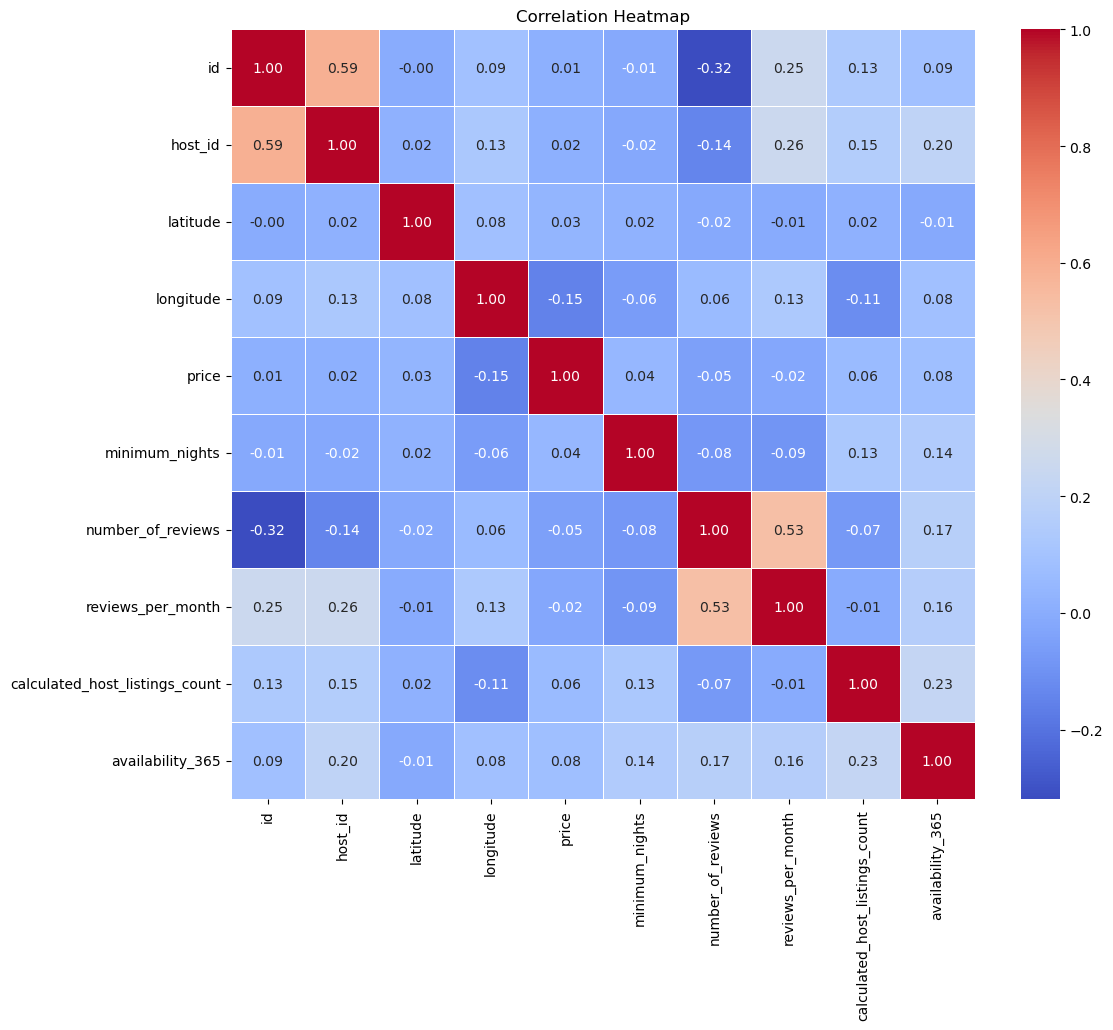

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,1.000000,0.588290,-0.003125,0.090908,0.010619,-0.013224,-0.319760,0.253252,0.133272,0.085468
host_id,0.588290,1.000000,0.020224,0.127055,0.015309,-0.017364,-0.140106,0.255046,0.154950,0.203492
latitude,-0.003125,0.020224,1.000000,0.084788,0.033939,0.024869,-0.015389,-0.009115,0.019517,-0.010983
longitude,0.090908,0.127055,0.084788,1.000000,-0.150019,-0.062747,0.059094,0.131599,-0.114713,0.082731
price,0.010619,0.015309,0.033939,-0.150019,1.000000,0.042799,-0.047954,-0.022373,0.057472,0.081829
minimum_nights,-0.013224,-0.017364,0.024869,-0.062747,0.042799,1.000000,-0.080116,-0.091942,0.127960,0.144303
number_of_reviews,-0.319760,-0.140106,-0.015389,0.059094,-0.047954,-0.080116,1.000000,0.530093,-0.072376,0.172028
reviews_per_month,0.253252,0.255046,-0.009115,0.131599,-0.022373,-0.091942,0.530093,1.000000,-0.006701,0.162980
calculated_host_listings_count,0.133272,0.154950,0.019517,-0.114713,0.057472,0.127960,-0.072376,-0.006701,1.000000,0.225701
availability_365,0.085468,0.203492,-0.010983,0.082731,0.081829,0.144303,0.172028,0.162980,0.225701,1.000000


In [75]:
def display_correlation_matrix(dataframe, show_correlation_plot=True):
    numeric_df = dataframe.select_dtypes(include=[np.number])
    correlation_matrix = numeric_df.corr()

    if show_correlation_plot:
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
        plt.title("Correlation Heatmap")
        plt.show()

    return correlation_matrix

display_correlation_matrix(df)



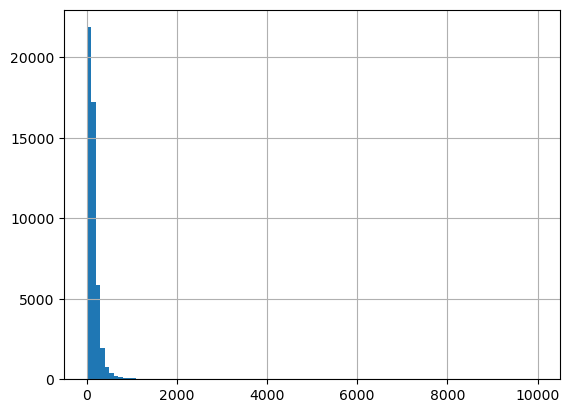

In [76]:
#Price Distribution
df["price"].hist(bins=100)
plt.show(block=True)

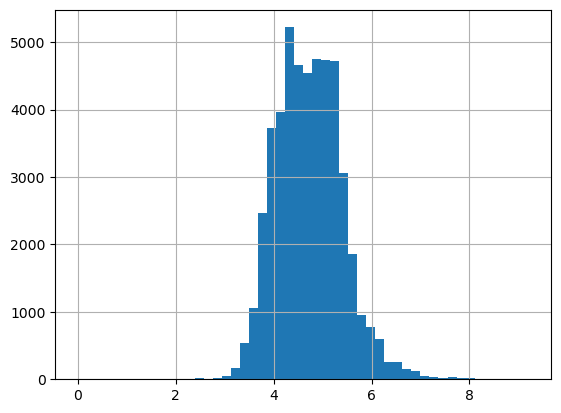

In [77]:
#Log Price Distribution
np.log1p(df['price']).hist(bins=50)
plt.show(block=True)

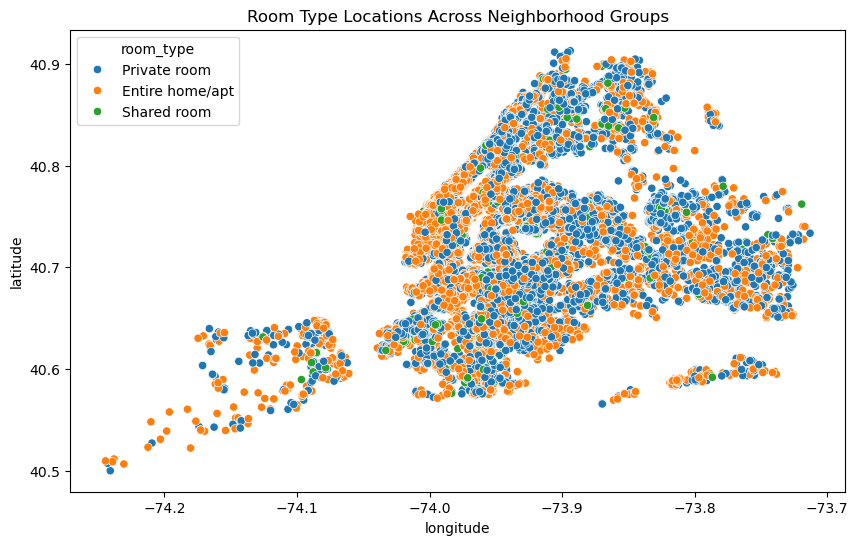

In [78]:
# Visualizing Room Types by Location and Neighborhood Group
plot_title = 'Room Type Locations Across Neighborhood Groups'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='room_type', data=df).set_title(plot_title)
plt.show()


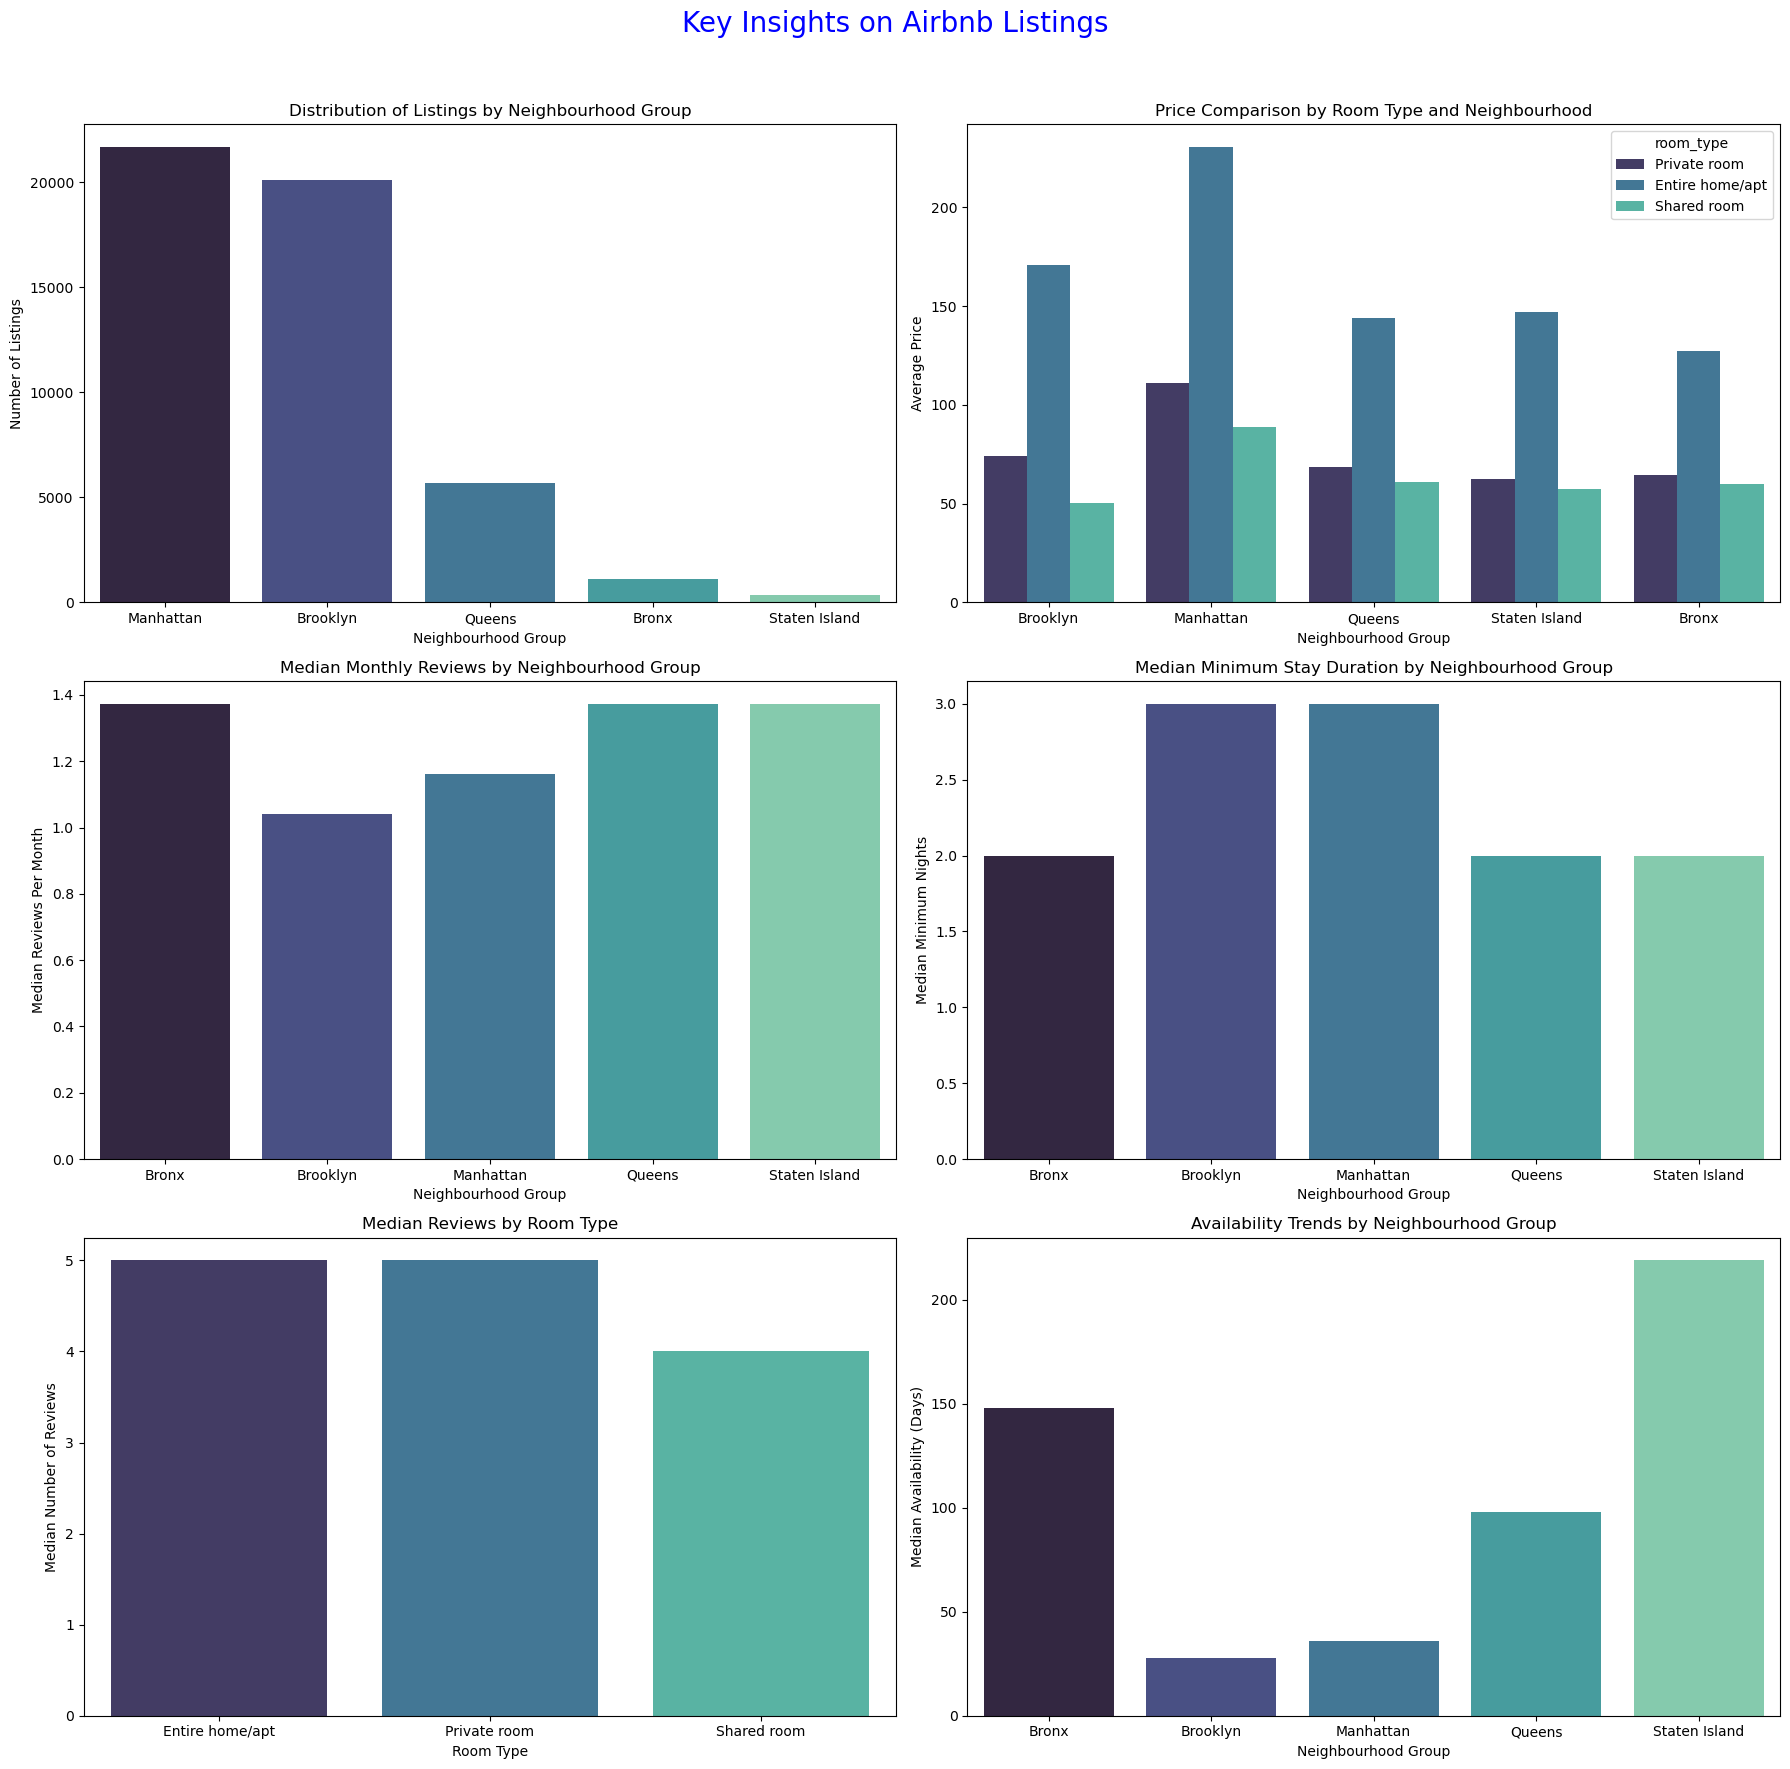

In [103]:
fig, axes = plt.subplots(3, 2, figsize=(18, 18))  # 3 rows, 2 columns for 6 plots
fig.suptitle("Key Insights on Airbnb Listings", fontsize=20, color='blue')
common_palette = "mako"

# 1. Bar Chart: Distribution by Neighbourhood Group
neighbourhood_counts = df['neighbourhood_group'].value_counts().reset_index()
neighbourhood_counts.columns = ['Neighbourhood Group', 'Count']
sns.barplot(
    x='Neighbourhood Group', 
    y='Count', 
    data=neighbourhood_counts, 
    palette=common_palette, 
    ax=axes[0, 0]
)
axes[0, 0].set_title('Distribution of Listings by Neighbourhood Group')
axes[0, 0].set_xlabel("Neighbourhood Group")
axes[0, 0].set_ylabel("Number of Listings")

# 2. Average Price by Neighbourhood Group and Room Type
sns.barplot(
    x="neighbourhood_group", 
    y="price", 
    hue="room_type", 
    data=df, 
    ci=None, 
    palette=common_palette, 
    ax=axes[0, 1]
)
axes[0, 1].set_title('Price Comparison by Room Type and Neighbourhood')
axes[0, 1].set_xlabel("Neighbourhood Group")
axes[0, 1].set_ylabel("Average Price")

# 3. Median Reviews Per Month by Neighbourhood Group
median_reviews = df.groupby(["neighbourhood_group"])['reviews_per_month'].median().reset_index()
sns.barplot(
    x='neighbourhood_group', 
    y='reviews_per_month', 
    data=median_reviews, 
    ci=None, 
    palette=common_palette, 
    ax=axes[1, 0]
)
axes[1, 0].set_title('Median Monthly Reviews by Neighbourhood Group')
axes[1, 0].set_xlabel("Neighbourhood Group")
axes[1, 0].set_ylabel("Median Reviews Per Month")

# 4. Median Minimum Nights by Neighbourhood Group
median_min_nights = df.groupby(["neighbourhood_group"])['minimum_nights'].median().reset_index()
sns.barplot(
    x='neighbourhood_group', 
    y='minimum_nights', 
    data=median_min_nights, 
    ci=None, 
    palette=common_palette, 
    ax=axes[1, 1]
)
axes[1, 1].set_title('Median Minimum Stay Duration by Neighbourhood Group')
axes[1, 1].set_xlabel("Neighbourhood Group")
axes[1, 1].set_ylabel("Median Minimum Nights")

# 5. Median Number of Reviews by Room Type
median_reviews_room = df.groupby(["room_type"])['number_of_reviews'].median().reset_index()
sns.barplot(
    x='room_type', 
    y='number_of_reviews', 
    data=median_reviews_room, 
    ci=None, 
    palette=common_palette, 
    ax=axes[2, 0]
)
axes[2, 0].set_title('Median Reviews by Room Type')
axes[2, 0].set_xlabel("Room Type")
axes[2, 0].set_ylabel("Median Number of Reviews")

# 6. Median Availability by Neighbourhood Group
median_availability = df.groupby(["neighbourhood_group"])['availability_365'].median().reset_index()
sns.barplot(
    x='neighbourhood_group', 
    y='availability_365', 
    data=median_availability, 
    ci=None, 
    palette=common_palette, 
    ax=axes[2, 1]
)
axes[2, 1].set_title('Availability Trends by Neighbourhood Group')
axes[2, 1].set_xlabel("Neighbourhood Group")
axes[2, 1].set_ylabel("Median Availability (Days)")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the main title
plt.show()

In [104]:
# Function to calculate outlier thresholds
def calculate_outlier_limits(dataframe, column, lower_quantile=0.05, upper_quantile=0.95):
    q1 = dataframe[column].quantile(lower_quantile)
    q3 = dataframe[column].quantile(upper_quantile)
    iqr = q3 - q1
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr

# Function to detect outliers
def has_outliers(dataframe, column):
    low, high = calculate_outlier_limits(dataframe, column)
    return dataframe[(dataframe[column] < low) | (dataframe[column] > high)].any().any()

# Function to cap outliers at thresholds
def cap_outliers(dataframe, column):
    low, high = calculate_outlier_limits(dataframe, column)
    dataframe.loc[dataframe[column] < low, column] = low
    dataframe.loc[dataframe[column] > high, column] = high

# Apply
for column in numeric_variables:
    if has_outliers(df, column):
        cap_outliers(df, column)


In [105]:
# Analyze rare categories in categorical variables
def analyze_rare_categories(dataframe, target_variable, categorical_columns):

    for col in categorical_columns:
        rare_summary = pd.DataFrame({
            'Frequency': dataframe[col].value_counts(),
            'Proportion': dataframe[col].value_counts() / len(dataframe),
            'Target_Mean': dataframe.groupby(col)[target_variable].mean()
        })
        print(f"Rare Category Analysis for '{col}':\n", rare_summary, "\n")

# Encode rare categories
def encode_rare_categories(dataframe, threshold=0.01):
    encoded_df = dataframe.copy()
    for col in encoded_df.select_dtypes(include=['object']).columns:
        frequencies = encoded_df[col].value_counts(normalize=True)
        rare_labels = frequencies[frequencies < threshold].index
        encoded_df[col] = encoded_df[col].apply(lambda x: 'Rare' if x in rare_labels else x)
    return encoded_df

analyze_rare_categories(df, "price", categorical_variables)
df_encoded = encode_rare_categories(df, threshold=0.01)

Rare Category Analysis for 'neighbourhood_group':
                      Frequency  Proportion  Target_Mean
neighbourhood_group                                    
Bronx                     1091    0.022313    85.805683
Brooklyn                 20104    0.411167   119.493285
Manhattan                21661    0.443011   183.362426
Queens                    5666    0.115881    96.175785
Staten Island              373    0.007629   102.030831 

Rare Category Analysis for 'room_type':
                  Frequency  Proportion  Target_Mean
room_type                                          
Entire home/apt      25409    0.519665   198.705498
Private room         22326    0.456611    86.096659
Shared room           1160    0.023724    68.627586 



In [106]:
df_encoded.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Rare,2787,Rare,Brooklyn,Rare,40.64749,-73.97237,Private room,149.0,1.0,9,Rare,0.210000,6,365
1,2595,Rare,2845,Rare,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225.0,1.0,45,Rare,0.380000,2,355
2,3647,Rare,4632,Rare,Manhattan,Harlem,40.80902,-73.94190,Private room,150.0,3.0,0,NaN,1.373221,1,365
3,3831,Rare,4869,Rare,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89.0,1.0,270,2019-07-05,4.640000,1,194
4,5022,Rare,7192,Rare,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80.0,10.0,9,Rare,0.100000,1,0


In [107]:
df_encoded.to_csv('EDA.csv', index=False)
print("File saved as 'EDA.csv")

File saved as 'EDA.csv
